## Read data

In [1]:
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import iris.coord_categorisation
import cf_units
import numpy

In [2]:
%matplotlib inline 

In [3]:
infile = '/g/data/ua6/DRSv2/CMIP5/NorESM1-M/rcp85/mon/ocean/r1i1p1/hfbasin/latest/hfbasin_Omon_NorESM1-M_rcp85_r1i1p1_200601-210012.nc'

In [4]:
cube = iris.load_cube(infile)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [5]:
print(cube)

northward_ocean_heat_transport / (W) (time: 1140; -- : 3; latitude: 166)
     Dimension coordinates:
          time                            x          -            -
          latitude                        -          -            x
     Auxiliary coordinates:
          region                          -          x            -
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: g...
          branch_time: 56940.0
          cmor_version: 2.6.0
          contact: Please send any requests or bug reports to noresm-ncc@met.no.
          creation_date: 2011-05-28T20:59:53Z
          experiment: RCP8.5
          experiment_id: rcp85
          forcing: GHG, SA, Oz, Sl, BC, OC
          frequency: mon
          history: 2011-05-28T20:59:53Z altered by CMOR: replaced missing value flag (1e+20)...
          initialization_method: 1
          institute_id: NCC
          institution: Norwegian Climate Ce

In [6]:
dim_coord_names = [coord.name() for coord in cube.dim_coords]
print(dim_coord_names)

['time', 'latitude']


In [7]:
aux_coord_names = [coord.name() for coord in cube.aux_coords]
print(aux_coord_names)

['region']


In [8]:
cube.coord('region')

AuxCoord(array(['atlantic_arctic_ocean', 'indian_pacific_ocean', 'global_ocean'], 
      dtype='<U200'), standard_name='region', units=Unit('1'), long_name='ocean basin', var_name='region')

In [9]:
global_cube = cube.extract(iris.Constraint(region='global_ocean'))

In [10]:
def convert_to_annual(cube, full_months=False):
    """Convert data to annual timescale.
    Args:
      cube (iris.cube.Cube)
      full_months(bool): only include years with data for all 12 months
    """

    iris.coord_categorisation.add_year(cube, 'time')
    iris.coord_categorisation.add_month(cube, 'time')

    cube = cube.aggregated_by(['year'], iris.analysis.MEAN)

    if full_months:
        cube = cube.extract(iris.Constraint(month='Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec'))
  
    cube.remove_coord('year')
    cube.remove_coord('month')

    return cube

In [11]:
global_cube_annual = convert_to_annual(global_cube)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/coords.py:495: VisibleDeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).
  bounds = bounds[keys + (Ellipsis, )]


In [12]:
print(global_cube_annual)

northward_ocean_heat_transport / (W) (time: 95; latitude: 166)
     Dimension coordinates:
          time                            x             -
          latitude                        -             x
     Scalar coordinates:
          region: global_ocean
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: g...
          branch_time: 56940.0
          cmor_version: 2.6.0
          contact: Please send any requests or bug reports to noresm-ncc@met.no.
          creation_date: 2011-05-28T20:59:53Z
          experiment: RCP8.5
          experiment_id: rcp85
          forcing: GHG, SA, Oz, Sl, BC, OC
          frequency: mon
          history: 2011-05-28T20:59:53Z altered by CMOR: replaced missing value flag (1e+20)...
          initialization_method: 1
          institute_id: NCC
          institution: Norwegian Climate Centre
          model_id: NorESM1-M
          modeling_realm: ocean
   

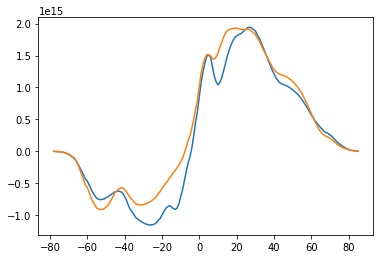

In [13]:
iplt.plot(global_cube_annual[5, ::])
iplt.plot(global_cube_annual[20, ::])
plt.show()

## Trends

In [ ]:
def _convert_to_seconds(time_axis):
    """Convert time axis units to seconds.
    Args:
      time_axis(iris.DimCoord)
    """

    old_units = str(time_axis.units)
    old_timestep = old_units.split(' ')[0]
    new_units = old_units.replace(old_timestep, 'seconds') 

    new_unit = cf_units.Unit(new_units, calendar=time_axis.units.calendar)  
    time_axis.convert_units(new_unit)

    return time_axis


def linear_trend(data, time_axis):
    """Calculate the linear trend.
    polyfit returns [a, b] corresponding to y = a + bx
    """    

    masked_flag = False

    if type(data) == numpy.ma.core.MaskedArray:
        if type(data.mask) == numpy.bool_:
            if data.mask:
                masked_flag = True
        elif data.mask[0]:
            masked_flag = True
            
    if masked_flag:
        return data.fill_value
    else:
        return numpy.polynomial.polynomial.polyfit(time_axis, data, 1)[-1]


def calc_trend(cube, running_mean=True, per_yr=True, remove_scaling=False):
    """Calculate linear trend.
    Args:
      cube (iris.cube.Cube)
      running_mean(bool, optional): 
        A 12-month running mean can first be applied to the data
      yr (bool, optional):
        Change units from per second to per year
    """

    time_axis = cube.coord('time')
    time_axis = _convert_to_seconds(time_axis)

    trend = numpy.ma.apply_along_axis(linear_trend, 0, cube.data, time_axis.points)
    trend = numpy.ma.masked_values(trend, cube.data.fill_value)

    if per_yr:
        trend = trend * 60 * 60 * 24 * 365.25

    return trend

In [14]:
trend_data = calc_trend(global_cube_annual, per_yr=True)
trend_unit = ' yr-1'

trend_cube = global_cube_annual[0, ::].copy()
trend_cube.data = trend_data
trend_cube.remove_coord('time')
trend_cube.units = str(global_cube_annual.units) + trend_unit

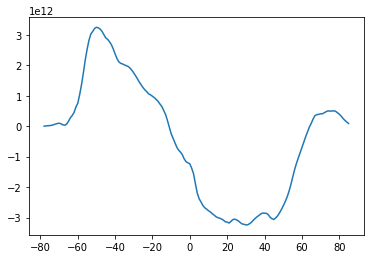

In [15]:
iplt.plot(trend_cube)
plt.show()

## Convergence

In [16]:
print(global_cube_annual)

northward_ocean_heat_transport / (W) (time: 95; latitude: 166)
     Dimension coordinates:
          time                            x             -
          latitude                        -             x
     Scalar coordinates:
          region: global_ocean
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: g...
          branch_time: 56940.0
          cmor_version: 2.6.0
          contact: Please send any requests or bug reports to noresm-ncc@met.no.
          creation_date: 2011-05-28T20:59:53Z
          experiment: RCP8.5
          experiment_id: rcp85
          forcing: GHG, SA, Oz, Sl, BC, OC
          frequency: mon
          history: 2011-05-28T20:59:53Z altered by CMOR: replaced missing value flag (1e+20)...
          initialization_method: 1
          institute_id: NCC
          institution: Norwegian Climate Centre
          model_id: NorESM1-M
          modeling_realm: ocean
   

In [20]:
global_cube_annual[0,:].data

masked_array(data = [-- -- -57354851669.333336 -1004496311637.3334 -3004642798250.6665
 -4470458023936.0 -8482549224789.333 -15212479163050.666
 -25273544911530.668 -34242697712981.332 -44638456337749.336
 -60629967350442.664 -83761352583850.67 -99921910824960.0
 -143290600346965.34 -195075177622186.66 -260622977597440.0
 -328486212337664.0 -392616874431829.3 -462723222951253.3
 -496041342271488.0 -566151762061994.6 -634153845041834.6
 -698225988206592.0 -750100558468437.4 -799492324458496.0
 -820098682759850.6 -830306567323648.0 -827656125109589.4
 -829765043530410.6 -809290039645525.4 -794645543343445.4
 -764408436708693.4 -731273658804906.6 -690722859297450.6
 -655077986183850.6 -643967174224554.6 -631453071179776.0
 -631796265910272.0 -643712250019840.0 -678498979719850.6
 -718448439066624.0 -781486300419413.4 -826443423197866.6
 -853591553561941.4 -885938204966912.0 -913235406487552.0
 -912426342023168.0 -909591305693866.6 -889732808572928.0
 -865856101111125.4 -842156740007253.4 

In [49]:
diffs_data = numpy.diff(global_cube_annual.data, axis=1)
lats = global_cube_annual.coord('latitude').points
diffs_lats = (lats[1:] + lats[:-1]) / 2.

In [50]:
print(diffs_data.shape)
print(len(diffs_lats))

(95, 165)
165


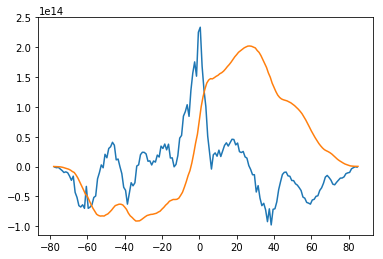

In [51]:
plt.plot(diffs_lats, diffs_data[0, :])
plt.plot(lats, global_cube_annual[0, ::].data / 10.0)
plt.show()

## Convergence trend

In [52]:
time_axis = global_cube_annual.coord('time')
time_axis = _convert_to_seconds(time_axis)

diffs_trend = numpy.ma.apply_along_axis(linear_trend, 0, diffs_data, time_axis.points)
diffs_trend = numpy.ma.masked_values(diffs_trend, global_cube_annual.data.fill_value)

In [53]:
print(diffs_trend.shape)

(165,)


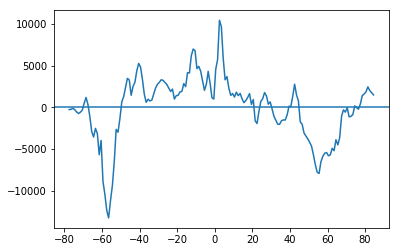

In [57]:
plt.plot(diffs_lats, diffs_trend * -1)
plt.axhline(y=0)
plt.show()